In [1]:
import numpy as np
import h5py
from scipy.signal import find_peaks
from os import listdir

class Comsol_data_analysis:

    def __init__(self, filename, path):
        self.filename = filename
        self.path = path
        self.file = h5py.File(self.path + self.filename, 'r')
        
        # x range data
        self._handle_x()

        # explore shape and variables
        _keys_list = list(self.file.keys())
        self.path_list = [[item for item in _keys_list if item != 'positions']]
        self.shape = [len(self.path_list[0])]
        self.variables = [] # initialiye variables 
        self._get_variables_dictionary(self.path_list[0]) # first step

        _sample_path = self.path_list[0][0] # initialize exploration
        _not_leaf = True
        while _not_leaf:
            try:
                _keys_list = self._get_sorted_keys_list(_sample_path)
                self.path_list.append(_keys_list)
                self.shape.append(len(_keys_list)) # 
                self._get_variables_dictionary(_keys_list) # update self.variables
                
                _sample_path += '/' + _keys_list[0]
            except:
                _not_leaf = False
        self.shape = tuple(self.shape)
    
    def analyse(self, func, outsize=1, outtype=float):
        # func is assumed to be a function of u(x)

        _shape = list(self.shape)
        if outsize > 1: _shape += [outsize]
        
        array = np.empty(_shape, dtype=outtype)

        # Define a recursive function to fill the array
        def _recursive_fill(array, func_inner, indices):
            if len(indices) == len(self.shape):
                array[tuple(indices)] = func_inner(self._index2u(indices))
            else:
                for i in range(_shape[len(indices)]):
                    _recursive_fill(array, func_inner, indices + [i])

        # Start filling the array
        _recursive_fill(array, func, [])
        return array
        
    def print(self):
        for d in self.variables:
            if "variable" == list(d.values())[0]:
                print(list(d.keys()))
            else:
                print(list(d.keys())[0] + f' = {list(d.values())[0][0]}, ..., {list(d.values())[0][-1]}    ({len(list(d.values())[0])} values)')
        
        print(f'x = {self.xmin}, ..., {self.xmax} ({self.nx} values),   dx = {self.dx}')
    
    def _sort_stringfloats(self, list_of_floatstrings):
        # input: ['a=1', 'a=0']
        # output: [0.0, 1.0], ['a=0', 'a=1']

        arr = np.zeros(len(list_of_floatstrings))
        name = list_of_floatstrings[0].split("=")[0]

        for i,key in enumerate(list_of_floatstrings):
            key_split = key.split("=")
            assert key_split[0] == name
            arr[i] = float(key_split[1])

        sort_inds = np.argsort(arr)
        return arr[sort_inds], list(np.array(list_of_floatstrings)[sort_inds])


    def _is_numeric(self, keys_list):
        sample_key = keys_list[0]
        sample_key_split = sample_key.split("=")
        if len(sample_key_split) > 1:
            return True
        else:
            return False

    def _get_variables_dictionary(self, keys_list):
        dic = {}
        if self._is_numeric(keys_list):
            arr, _ = self._sort_stringfloats(keys_list)
            name = keys_list[0].split("=")[0]
            if name == 't': self._handle_time(arr)
            dic[name] = arr
        else:
            for key in keys_list:
                dic[key] = "variable"
            
        self.variables.append(dic)

    def _handle_x(self):
        self.x_range = np.array(self.file['positions/X'])
        self.xmin = self.x_range[0]
        self.xmax = self.x_range[-1]
        self.dx = self.x_range[1]-self.x_range[0]
        self.nx = len(self.x_range)

    def _handle_time(self, arr):
        self.t_range = arr
        self.tmin = arr[0]
        self.tmax = arr[-1]
        self.nt = len(arr)

    def _get_sorted_keys_list(self, _sample_path):
        ini_list = list(self.file[_sample_path].keys())
        if self._is_numeric(ini_list):
            _, new_list = self._sort_stringfloats(ini_list)
            return new_list
        else:
            return ini_list

    def _index2path(self, indicies):
        _path_string = ''
        for i,ind in enumerate(indicies):
            _path_string += self.path_list[i][ind] + '/'
        return _path_string[:-1] # not the last /

    def _index2u(self, indicies):
        return np.array(self.file[self._index2path(indicies)])


In [2]:
# h5 file(s) location
path_to_h5_files = "/scratch/n/Natan.Dominko/h5_data/"
# path_to_h5_files = "/home/n/Natan.Dominko/Downloads/"
# list all files in folder
filenames = [f for f in listdir(path_to_h5_files) if (f[-3:] == ".h5")]
print(f"Files in current directory: {filenames}")

Files in current directory: ['logistic_t_1e10_eps_1e2-1e3.h5', 'test.h5']


In [3]:
# h5 to np array
# --------------
filename = 'logistic_t_1e10_eps_1e2-1e3.h5'
# ini file
h5file = Comsol_data_analysis(filename, path_to_h5_files)
h5file.print()

# memory in MB
print(f"Array size in Mb: {8 * np.prod(np.array(h5file.shape)) / 1000000}, it will take around {8 * np.prod(np.array(h5file.shape)) / 1000000 * 10} seconds. Consider before constructing numpy array.")
pde_sol = h5file.analyse((lambda u: u), outsize=h5file.nx)

['c', 'rho']
epsilon = 0.001, ..., 0.01    (11 values)
t = 1.0, ..., 10000000000.0    (101 values)
x = 0.00735, ..., 146.99265 (10000 values),   dx = 0.0146999999999999
Array size in Mb: 0.017776, it will take around 0.17776 seconds. Consider before constructing numpy array.


<ipython-input-1-b78416560991>:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "variable" == list(d.values())[0]:


In [4]:
# h5 to peaks
# --------------
# get peaks with in-place function
peaks_array = h5file.analyse((lambda u: h5file.x_range[find_peaks(u)[0]]), outtype=list)

In [5]:
# h5 to peaks diff
# --------------
# get peaks with oofp function
def peaks_diff(u):
    peaks_array = np.array(h5file.x_range[find_peaks(u)[0]])
    return peaks_array[1:] - peaks_array[:-1]

peaks_diff_array = h5file.analyse(peaks_diff, outtype=np.ndarray)

In [6]:
# h5 to N peaks
# --------------
# get N peaks with oofp function
def n_peaks(u):
    return len(np.array(h5file.x_range[find_peaks(u)[0]])) + 1

n_peaks_array = h5file.analyse(n_peaks)

In [7]:
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib widget

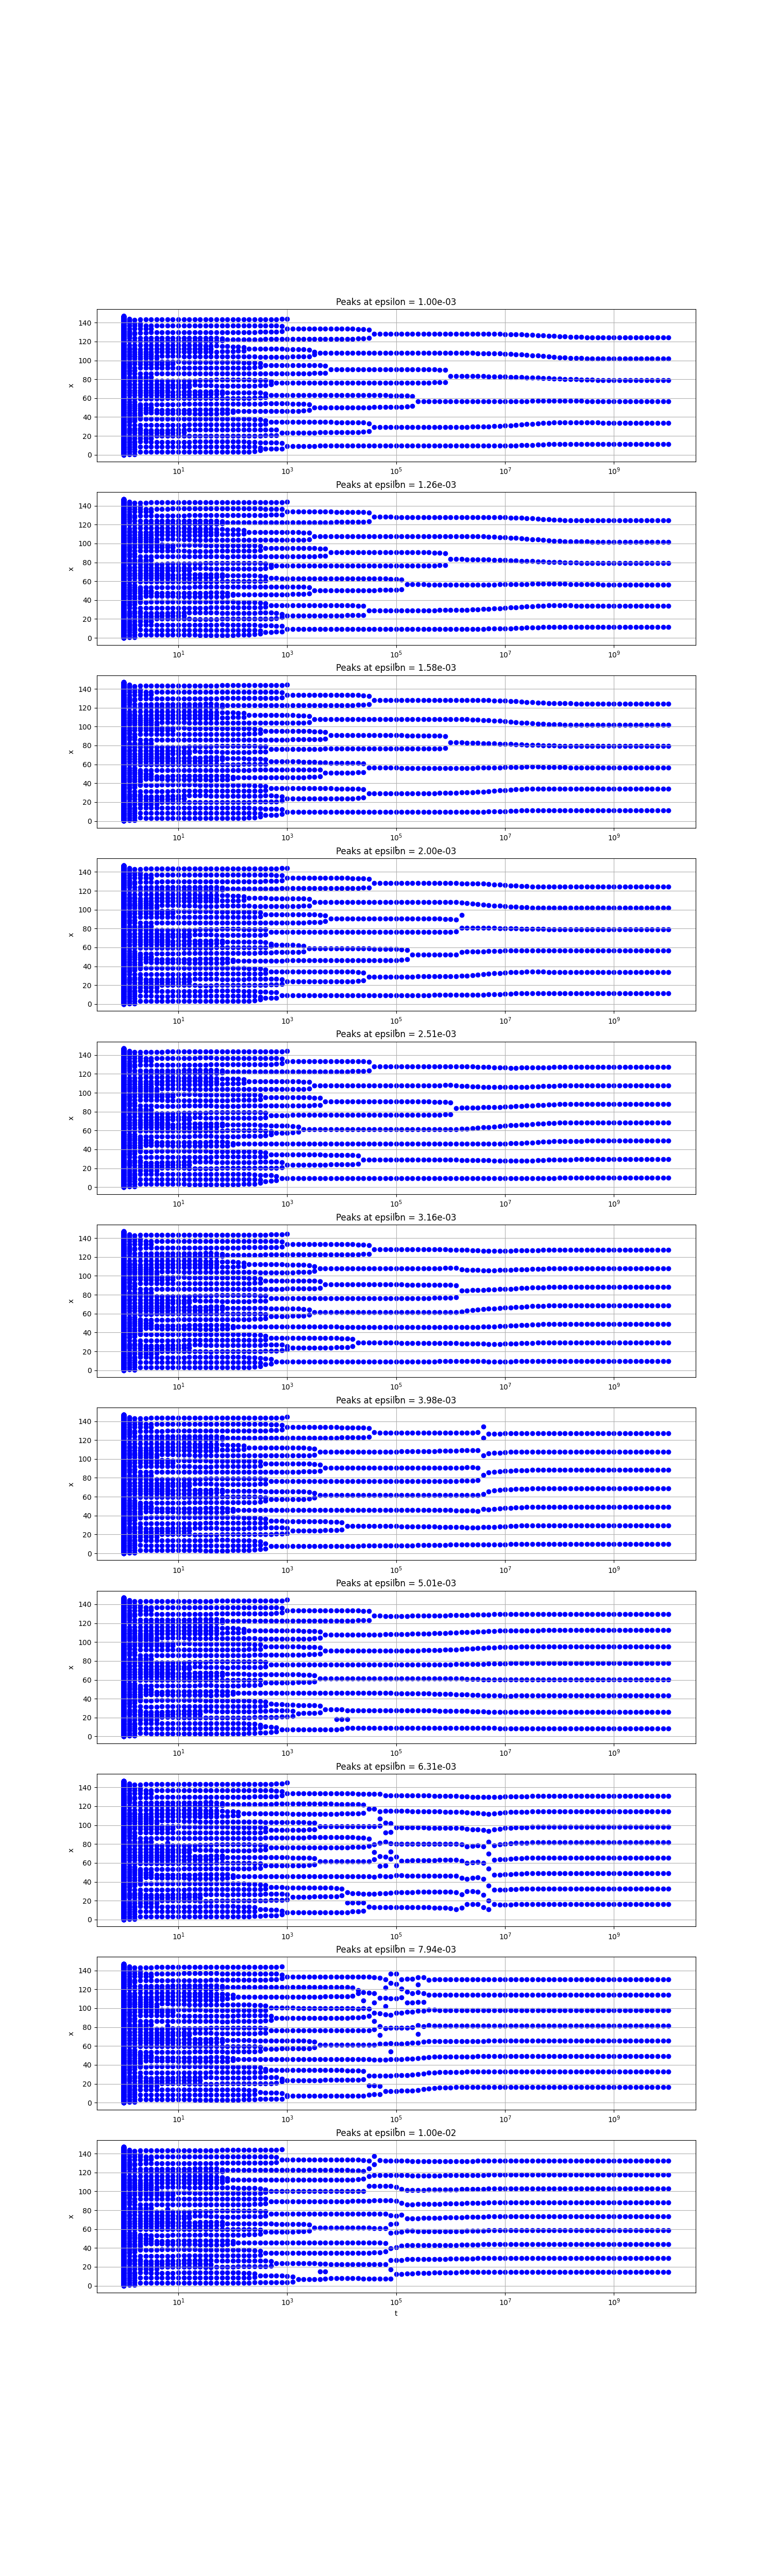

In [8]:
# peaks position in time @ fixed epsilon
i = 0 # rho variable
# j = -1 # epsilon=0.001

fig, axs = plt.subplots(h5file.shape[1], figsize=(15,50))
for j,ax in enumerate(axs):
    for k in range(h5file.shape[2]):
        ax.scatter([h5file.t_range[k]]*len(peaks_array[i,j,k]), peaks_array[i,j,k], color='b')
    ax.set_xscale('log')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_title(f'Peaks at epsilon = {h5file.variables[1]["epsilon"][j]:.2e}')
    ax.grid()
plt.show()

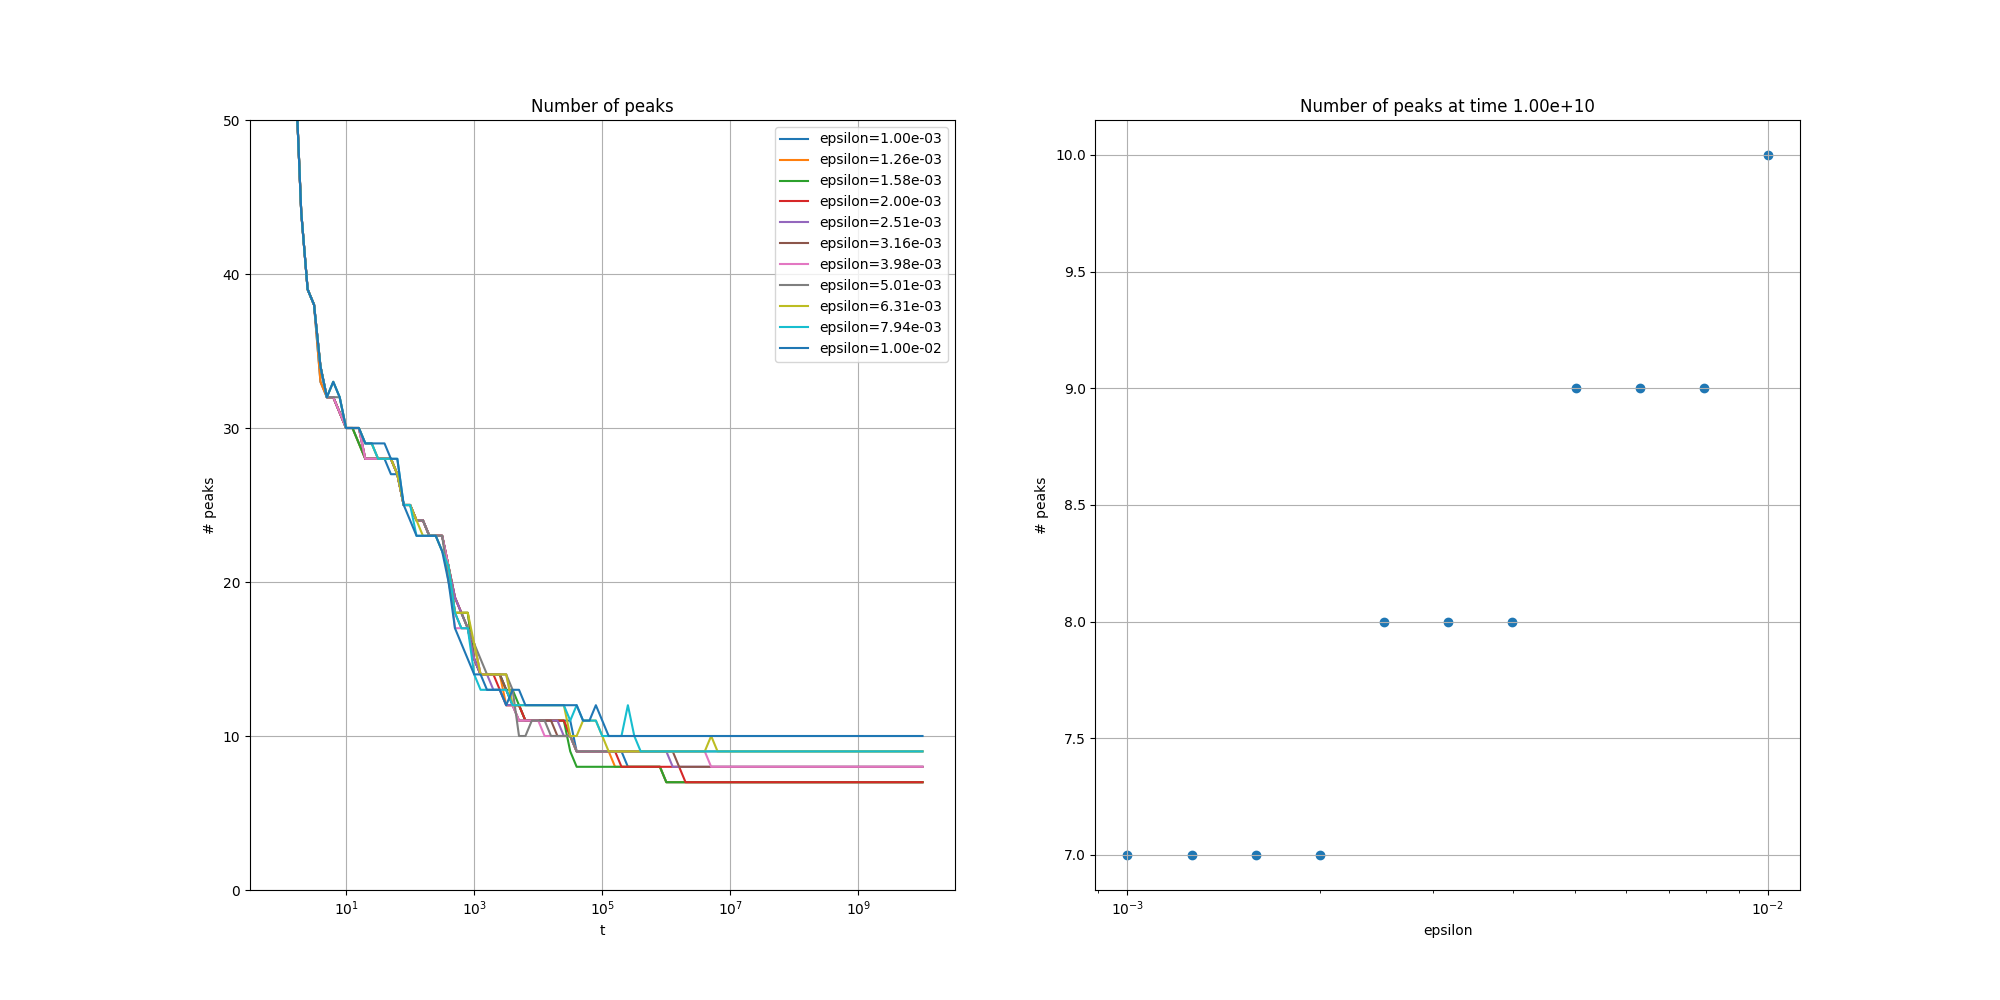

In [9]:
# number of peaks in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, n_peaks_array[i,j], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_ylim(0, 50)
ax.set_xlabel('t')
ax.set_title(f'Number of peaks')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], n_peaks_array[i,:,k])
ax.set_title(f'Number of peaks at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('# peaks')
    ax.grid()
plt.show()

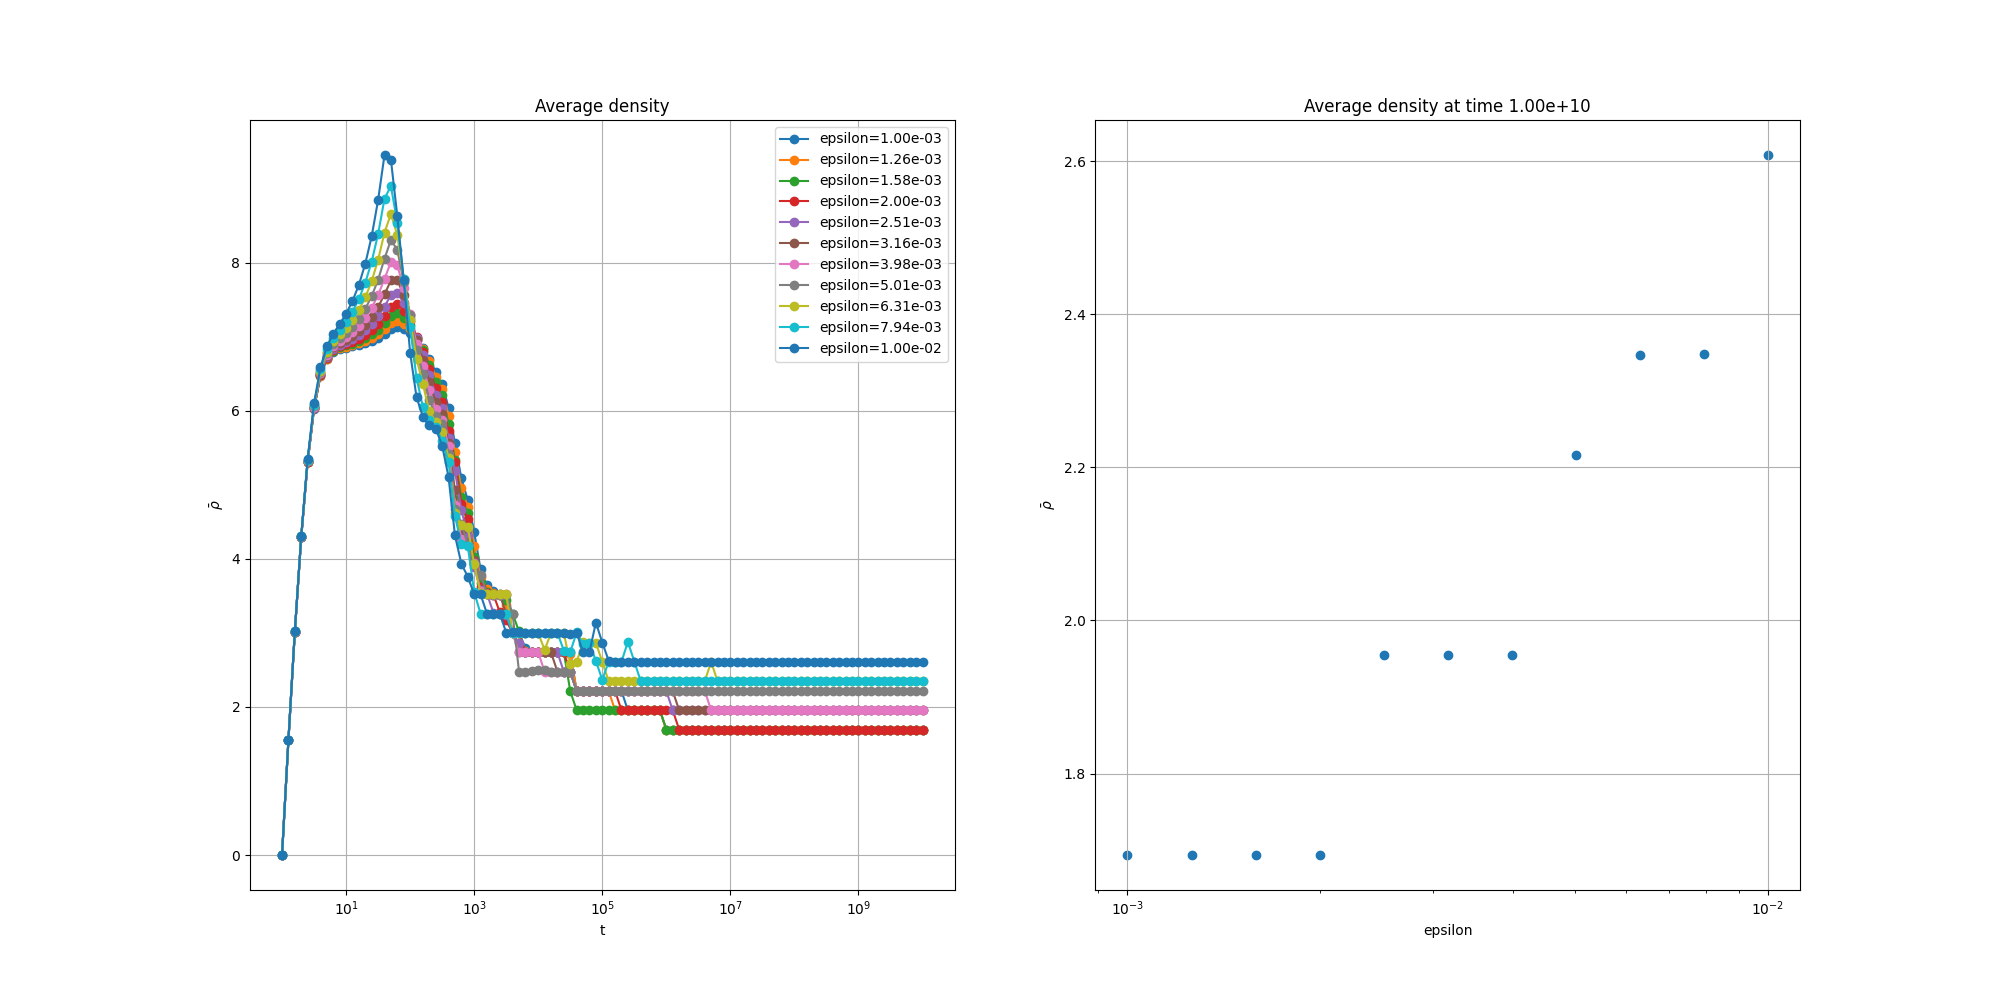

In [10]:
# number of peaks in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
rho = np.sum(pde_sol, axis=-1) / h5file.xmax
# per peak normalization
# rho /= n_peaks_array
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, rho[i,j], '-o', label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average density')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], rho[i,:,k])
ax.set_title(f'Average density at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\bar \\rho$')
    ax.grid()
plt.show()

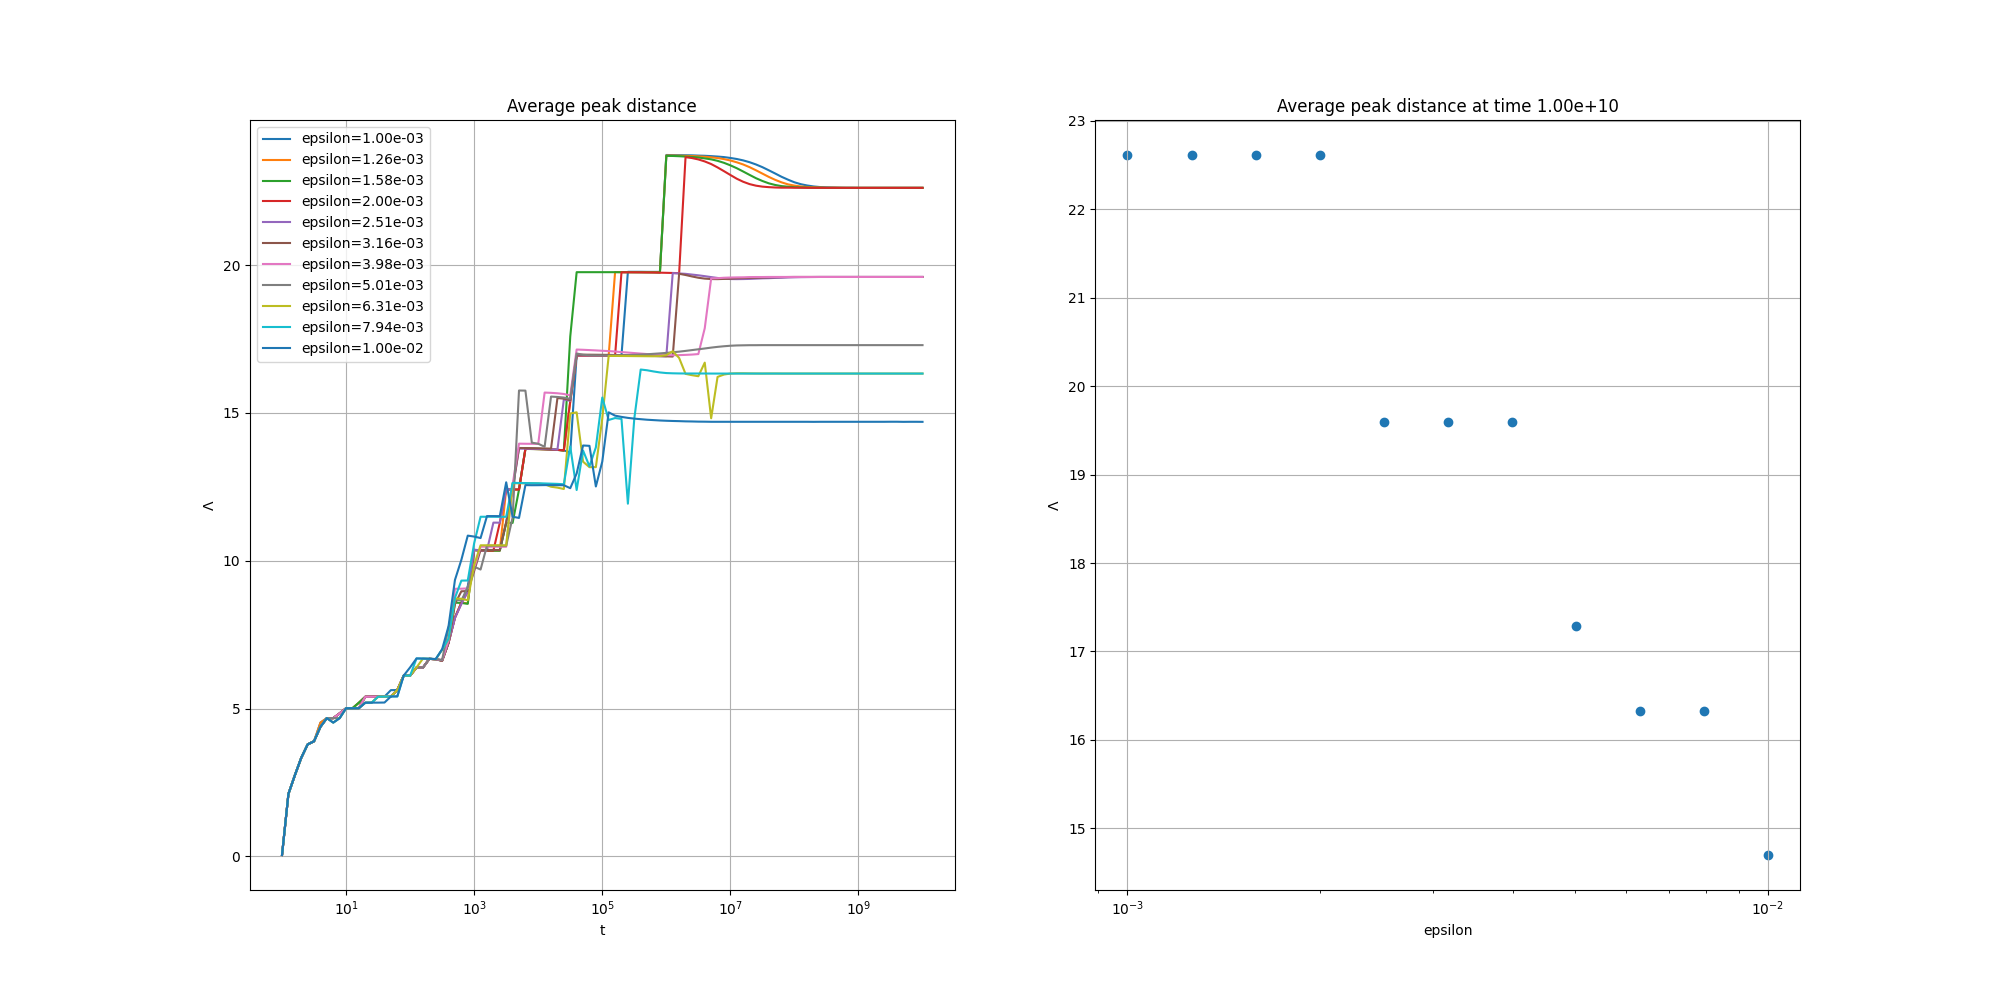

In [11]:
# peaks distance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.mean(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average peak distance')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], [np.mean(peaks) for peaks in peaks_diff_array[i,:,k]])
ax.set_title(f'Average peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\Lambda$')
    ax.grid()
plt.show()

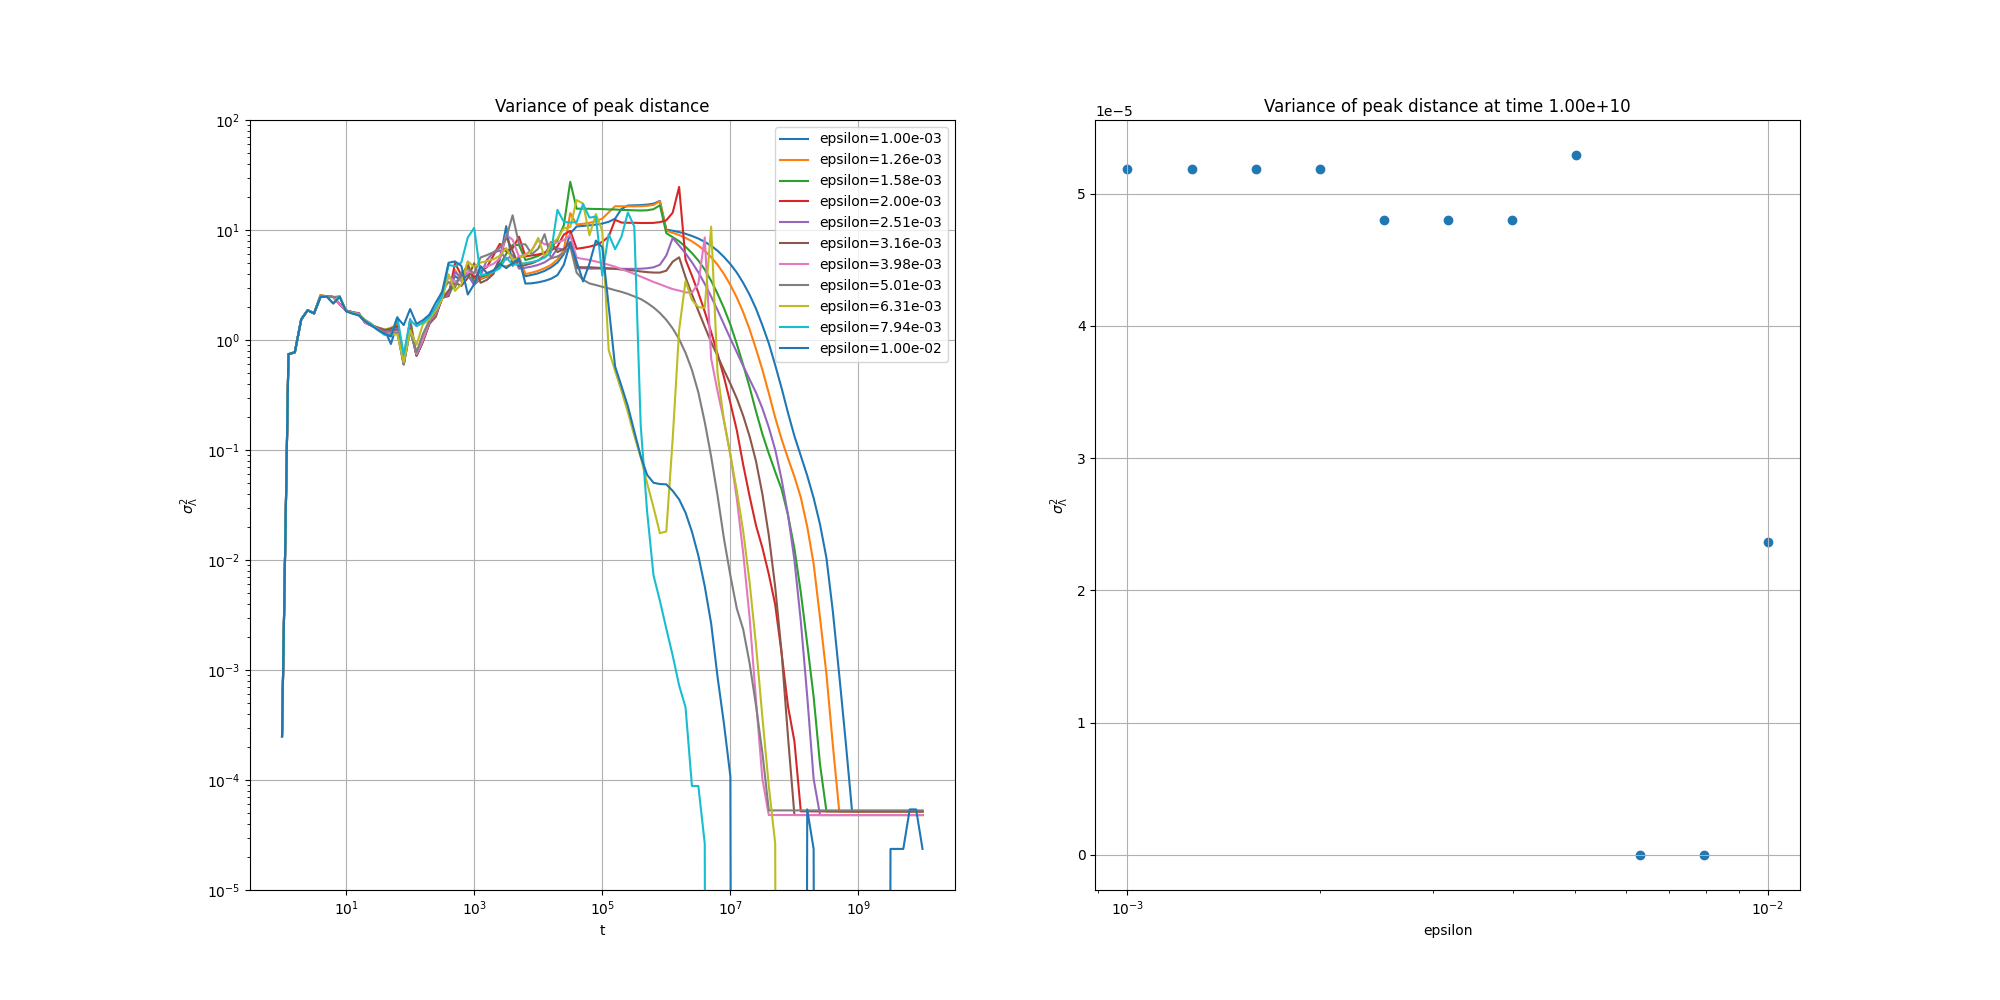

In [12]:
# peaks distance variance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.var(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.set_xlabel('t')
ax.set_title(f'Variance of peak distance')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], [np.var(peaks) for peaks in peaks_diff_array[i,:,k]])
ax.set_title(f'Variance of peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\sigma_\\Lambda^2$')
    ax.grid()
plt.show()

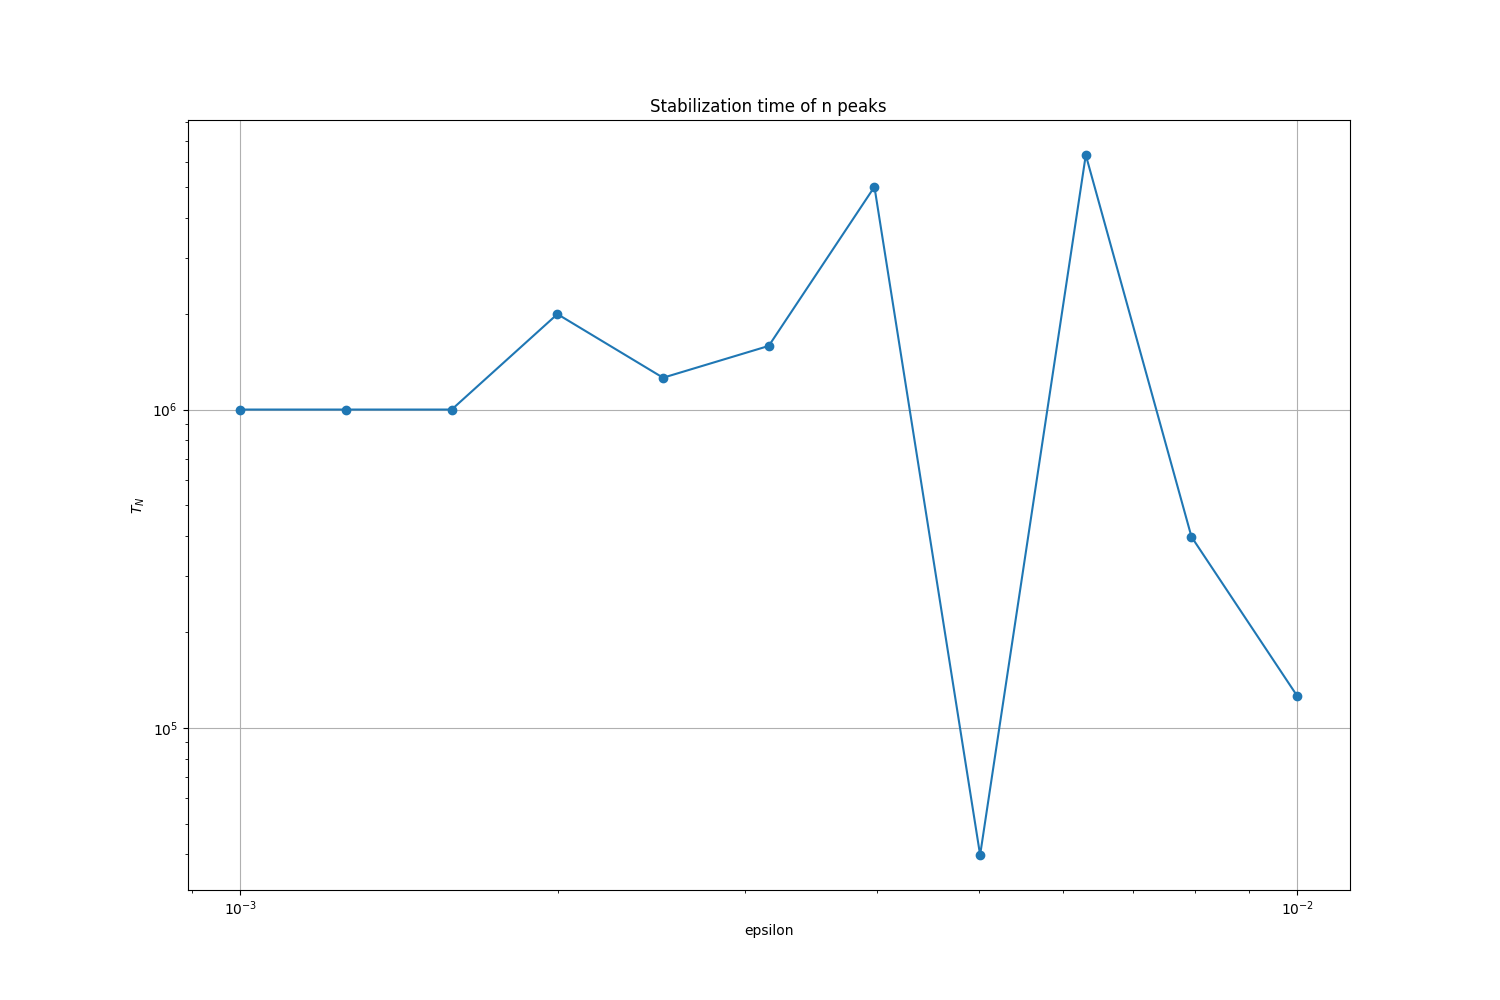

In [13]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.gradient(n_peaks_array[i,j,:]) != 0.)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of n peaks')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_N$')
ax.grid()
plt.show()

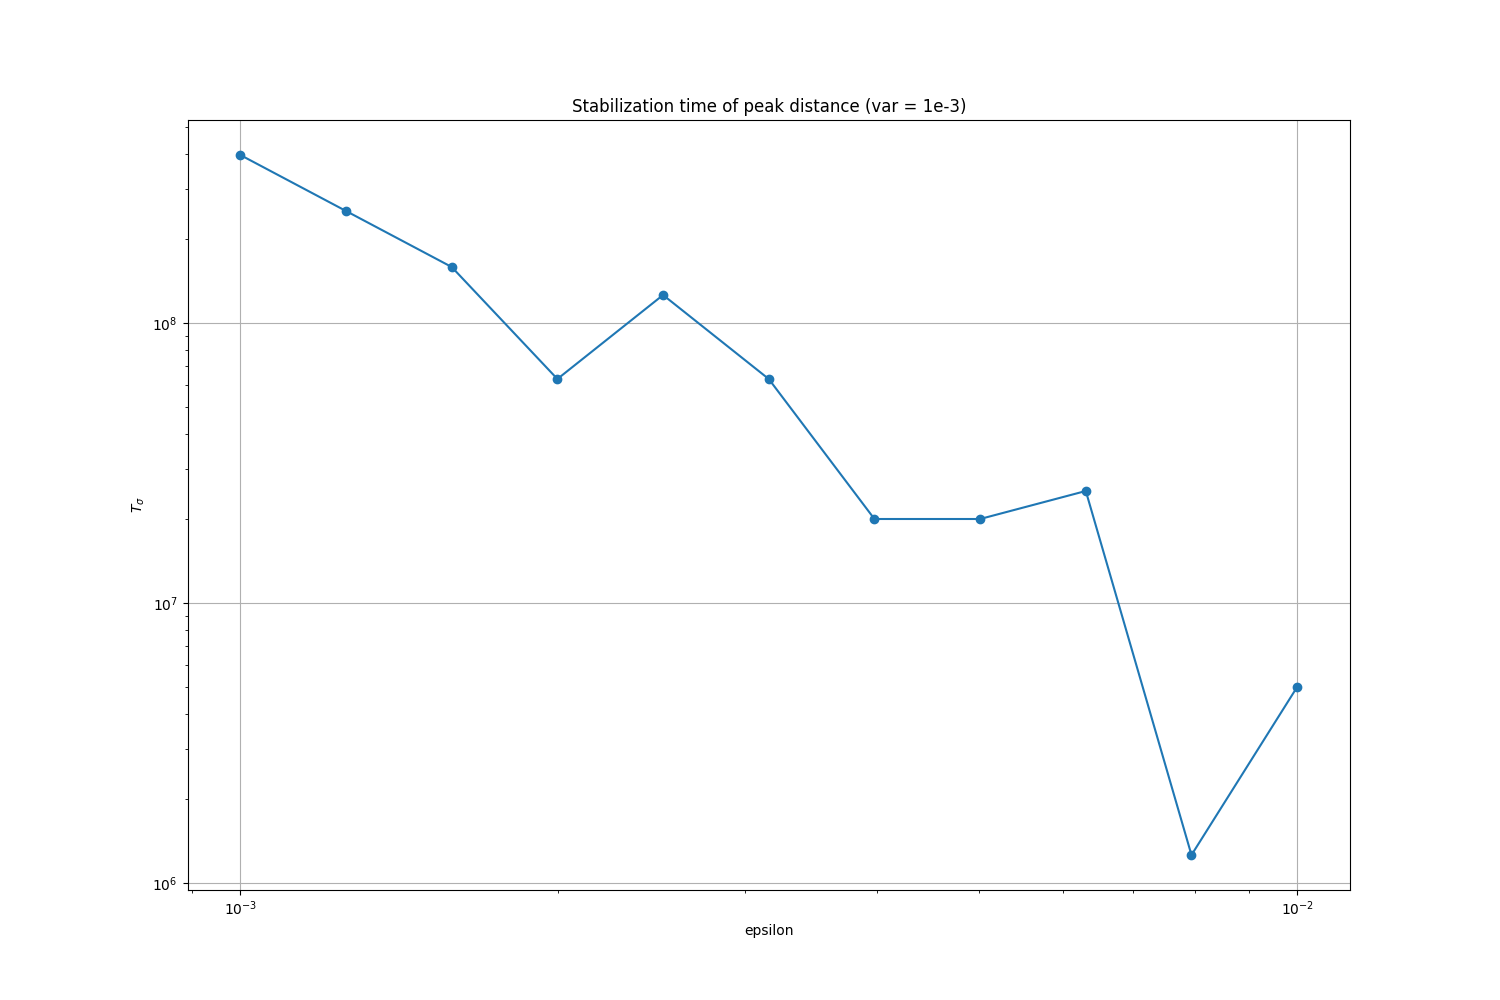

In [14]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.array([np.var(peaks) for peaks in peaks_diff_array[i,j]]) > 1e-3)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of peak distance (var = 1e-3)')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_\\sigma$')
ax.grid()
plt.show()

In [15]:
h5file.t_range[np.where(np.abs(np.gradient(n_peaks_array[i,4,:])) > 0.)]

array([1.0000e+00, 1.2589e+00, 1.5849e+00, 1.9953e+00, 2.5119e+00,
       3.1623e+00, 3.9811e+00, 5.0119e+00, 6.3096e+00, 7.9433e+00,
       1.0000e+01, 1.5849e+01, 1.9953e+01, 5.0119e+01, 6.3096e+01,
       7.9433e+01, 1.0000e+02, 1.2589e+02, 1.5849e+02, 1.9953e+02,
       3.1623e+02, 3.9811e+02, 5.0119e+02, 6.3096e+02, 7.9433e+02,
       1.0000e+03, 1.2589e+03, 1.5849e+03, 1.9953e+03, 2.5119e+03,
       3.1623e+03, 3.9811e+03, 5.0119e+03, 1.9953e+04, 2.5119e+04,
       3.1623e+04, 3.9811e+04, 1.0000e+06, 1.2589e+06])

In [16]:
h5file.variables[1]["epsilon"]

array([0.001    , 0.0012589, 0.0015849, 0.0019953, 0.0025119, 0.0031623,
       0.0039811, 0.0050119, 0.0063096, 0.0079433, 0.01     ])

In [17]:
h5file.t_range[np.newaxis, np.newaxis, :][np.gradient(n_peaks_array, axis=2) == -1.]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2

In [ ]:
h5file.t_range[np.where(np.abs(np.gradient(n_peaks_array[i,j,:])) == 1.)][-1]

100000.0

In [ ]:
np.shape(h5file.t_range[np.newaxis, np.newaxis, :])

(1, 1, 101)

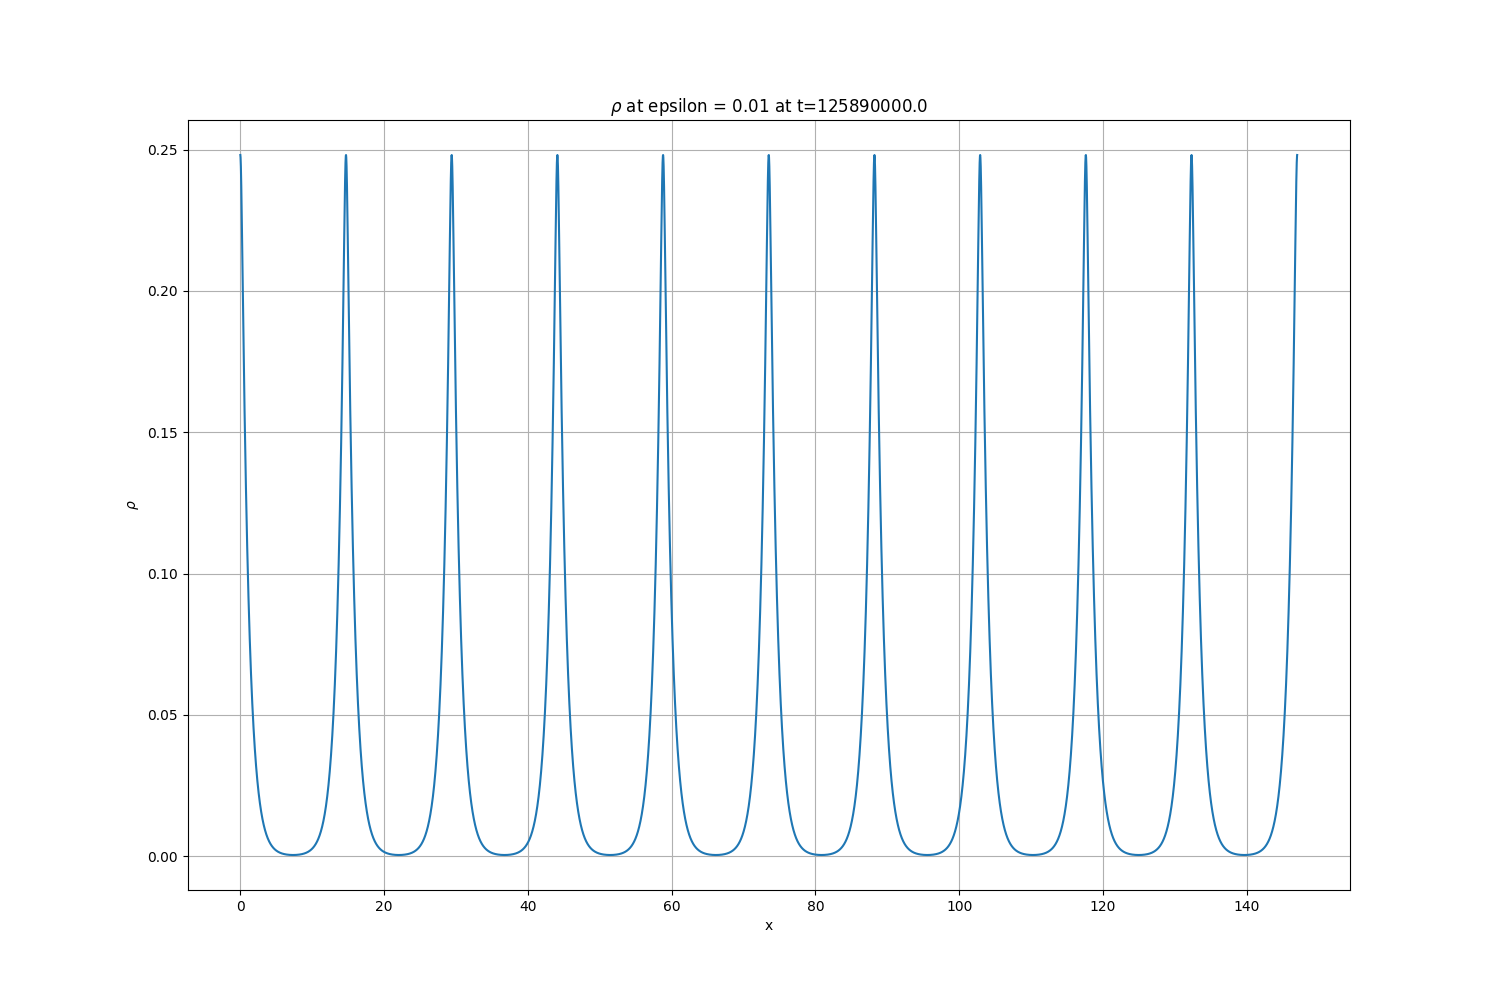

In [ ]:
# peaks distance in time @ many epsilon
i = 0
j = -1
k = -20
plt.close("all")
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.x_range, pde_sol[i,j,k,:])
ax.set_xlabel('x')
ax.set_ylabel('$\\rho$')
ax.set_title(f'$\\rho$ at epsilon = {h5file.variables[1]["epsilon"][j]} at t={h5file.t_range[k]}')
ax.grid()
plt.show()

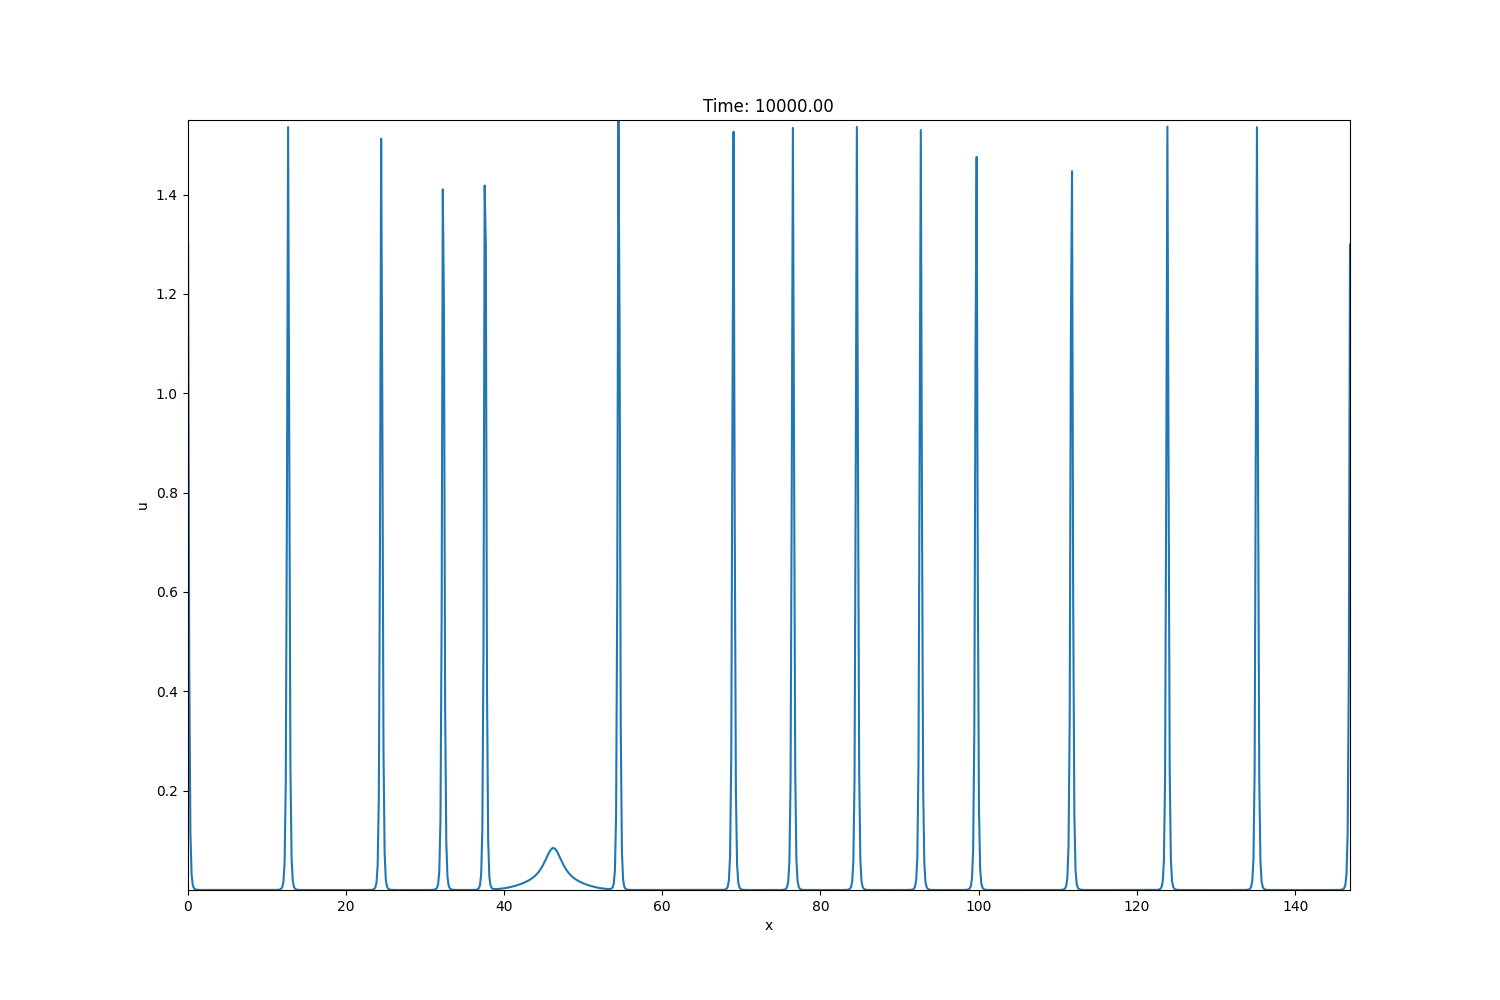

In [ ]:
file = h5py.File(path_to_h5_files + 'test36.h5', 'r')
x_range = np.array(file['positions/X'])

t_range_string = np.array(list(file['c/parameter_set_0'].keys()))
t_range = np.array([float(t_string[2:]) for t_string in t_range_string])
ind_sorted = np.argsort(t_range)
t_range_sorted = t_range[ind_sorted]
t_range_string_sorted = t_range_string[ind_sorted]

# Parameters
L = x_range[-1]  # Length of the domain
T = t_range_sorted[-1]   # Total time
Nx = len(x_range)  # Number of spatial points
Nt = len(t_range_sorted)  # Number of time steps

pde_sol_rho = np.zeros((Nt,Nx))

for i,t_string in enumerate(t_range_string_sorted):
    pde_sol_rho[i, :] = np.array(file['rho/parameter_set_0/' + t_string])
    # pde_sol_c = np.array(file['c/parameter_set_0/' + t_string])

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Animation function
def animate(i):
    plt.cla()
    plt.plot(x_range, pde_sol_rho[i,:])
    plt.title(f'Time: {t_range_sorted[i]:.2f}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.xlim(0.0, L)
    plt.ylim(np.min(pde_sol_rho[-1,:]), np.max(pde_sol_rho[-1,:]))

# Create animation
fig = plt.figure(figsize=(15,10))
ani = FuncAnimation(fig, animate, frames=Nt, interval=50)
ani.save('animation.gif', writer='imagemagick', fps=10)# Display animation
plt.show()
